In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import torch
from torch import nn
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.optim as optim
import math
import random

if torch.cuda.is_available():
  dev = 'cuda'
  print("Cuda avaiable. Device used to train the model:", dev)
else: 
  dev = 'cpu'
  print("Cuda not avaiable. Device used to train the model:", dev)


Cuda not avaiable. Device used to train the model: cpu


# **A harmonic series dataset**

This dataset generates an input signal and an output signal, given a harmonic distribution and a number of cycles we want to compute.\
Input = ramp signal\
Ouput = harmonic wave

In [2]:
# Third version of HarmonicSeriesDataset
class HarmonicSeriesDataset(Dataset):
    
    def __init__(self, harmonics,n_periods=1):
        self.harmonics = torch.tensor(harmonics)
        #self.len = n_periods*2*harmonics.size()[0]
        self.sequence_len = n_periods*2*harmonics.size()[0]
        self.sample_rate = 2*harmonics.size()[0]
        self.sample_time = 1/(2*harmonics.size()[0])
        self.n_freqs = harmonics.size()[0]
        self.phases = torch.zeros(self.n_freqs)
        self.freqs = torch.linspace(start=0, end=self.n_freqs-1, steps=self.n_freqs)
    
    def __len__(self):
        return 100

    def __getitem__(self, idx):
      self.phases[:] = 0
      check = np.random.choice([True,False])
      on_off = torch.ones(self.len) if(check) else torch.zeros(self.len)
      # delay = np.random.randint(0,self.len-2)
      d_1 = np.random.randint(0,self.len/2)
      d_2 = np.random.randint(self.len/2,self.len-2)
      on_off[d_1:d_2] = 0 if(check) else 1
      #input[0:delay] = 0
      input = torch.zeros(self.len)
      output = torch.zeros(self.len)
      
      for i in range(self.len):  
        if i == 0:
          input[i] = self.sample_time if on_off[i] else 0
        else:
          input[i] = input[i-1] + self.sample_time if on_off[i] else 0
        
        # Clip input from 0 to 1
        input[i] = input[i].clip(0,1)

        self.phases += (2*np.pi*self.freqs/self.sample_rate)
        self.phases = self.phases * on_off[i]
        output[i] = torch.sum(harmonics*torch.sin(self.phases))*input[i]

      return input, output

Let's generate a dataset and plot its content.

<ipython-input-2-87a116ac7a02>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.harmonics = torch.tensor(harmonics)


240
4
Samples.shape: torch.Size([60, 240, 2])


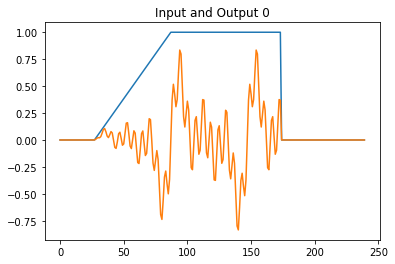

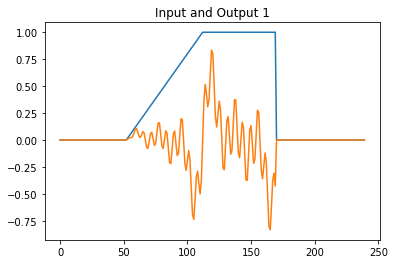

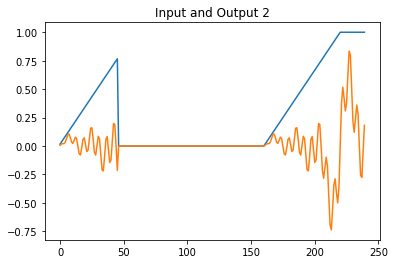

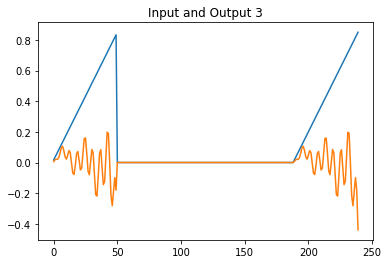

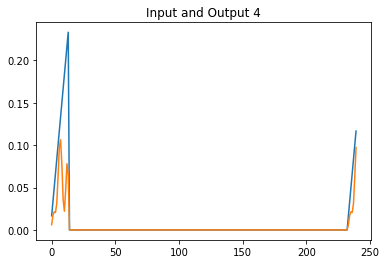

In [3]:
# Dataset configuration
period_len = 60
n_periods = 4
# Generate a distribution of harmonics
harmonics = torch.zeros(period_len//2)
harmonics[1] = 1
harmonics[2] = 1
harmonics[3] = 1
harmonics[10] = 1
# Normalize distribution
harmonics = harmonics/torch.sum(harmonics)

# Create dataset
batch_size = 60
dataset = HarmonicSeriesDataset(harmonics,n_periods)
train_dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size)

# Sample storage to plot
signal_len = len(train_dataloader)
print(period_len*n_periods)
print(signal_len)

# Examples of dataset
samples = torch.zeros(batch_size,period_len*n_periods,2)

samples[:,:,0],samples[:,:,1] = next(iter(train_dataloader))


print("Samples.shape:",samples.shape)
for i in range(5):
  plt.plot(samples[i,:,0].detach().numpy())
  plt.plot(samples[i,:,1].detach().numpy())
  plt.title("Input and Output {}".format(i))
  plt.show()


# **Dataset Example.** 

Let's generate a dataset for the models to predict an output $A$ samples ahead.

torch.Size([60, 240, 2])


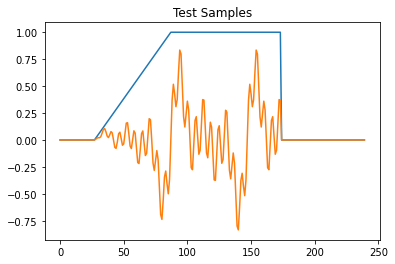

In [4]:
print(samples.shape)
plt.show()

fig, ax = plt.subplots()
ax.plot(samples[0,:,:].detach().cpu().numpy())
# ax.plot(test_samples.view(-1).detach().cpu().numpy())
plt.title("Test Samples")
plt.show()

# **Gated Recurrent Unit (GRU)**

In [5]:
class GRUmodel(nn.Module):
  def __init__(self, input_size, output_size, hidden_dim, num_layers=1):
    super(GRUmodel, self).__init__()
    self.num_layers = num_layers
    self.hidden_dim = hidden_dim
    # GRU (input)
    self.gru = nn.GRU(input_size, hidden_dim, num_layers=num_layers, batch_first=True)
    # Fully connected (output)
    self.lin = nn.Linear(hidden_dim, output_size)
    
  # Forward method
  def forward(self, seq):

    input = seq  # input.shape = (N,L,input_size)
    
    out, hidden = self.gru(input) # out.shape = (L,hidden_dim)...hidden.shape = (num_layers, hidden_dim)
    out = self.lin(out) # out.shape = (1,1)
    return out


In [ ]:
def gru_evaluate_on_data(net, eval_input, target, device, plot=False):

  L = target.shape[1] # sequence length
  batch_size = target.shape[0] # batch size
  random = np.random.randint(0,batch_size-2)
  target = target[random,:,:].unsqueeze(0).to(device) # ([N,L,1])
  # seq = torch.ones([batch_size,L,1]).to(device) # ([N,L,1])
  seq = eval_input[random,:,:].unsqueeze(0).to(device)

  with torch.no_grad():
    pred = net(seq)
      # Calculate evaluation loss
  eval_loss = torch.sum(torch.abs(target-pred))

  # Plotting results
  if(plot):
    fig, ax = plt.subplots()
    print("[TEST ON DATA] Eval loss {}".format(eval_loss))
    ax.plot(seq[0,:,:].detach().numpy())
    ax.plot(target[0,:,:].detach().numpy())
    ax.plot(pred[0,:,:].detach().numpy())
    plt.show()

  return eval_loss
  
def gru_train(net, epochs, train_dataloader, device):
  
  net.train()

  # Define Loss, Optimizer, ecc.
  criterion = nn.L1Loss()
  optimizer = optim.Adam(net.parameters(), lr=0.001)

  best_eval_loss = np.inf

  # target = train_samples[:,:,1].unsqueeze(2).to(device) #([N,L,1])
  # train = train_samples[:,:,1].unsqueeze(2).to(device) #([N,L,1]) 
  # L = target.shape[1] # sequence length
  # n_batches = target.shape[0] # batch size
  epochs_loss = np.zeros(epochs)

  for epoch in range(epochs): 
    optimizer.zero_grad()
    running_loss = 0.0

    for i,sample in enumerate(train_dataloader):
      target,seq = sample
      target = target.unsqueeze(2).to(device)
      seq = seq.unsqueeze(2).to(device)
      prediction = net(seq)
      loss = criterion(prediction, target) # Calculate loss
      loss.backward() # Backpropagation and calculates gradients
      optimizer.step() # Updates the weights
    # Print statistics
    running_loss += loss.item() # To calculate epochs' mean loss
    plot = True if (epoch%(epochs/16)==0) else False
    eval_loss = gru_evaluate_on_data(net, seq, target, device, plot=plot)
    
    epochs_loss[epoch] = eval_loss # For plotting loss during epochs

    if eval_loss < best_eval_loss:
      best_eval_loss = eval_loss
      torch.save(net.state_dict(), 'best_gru.pt')

    if (epoch%(epochs/20) == 0):
        print('Epoch: {}/{}.............'.format(epoch, epochs), end=' ')
        print("Train Loss: {:.4f} - Best Eval {:.4f}".format(running_loss, best_eval_loss))
    
    running_loss = 0.0

  print("---------- FINISHED TRAINING ----------")

  # Print Eval Loss
  x_ = np.linspace(0, epochs-1, epochs)
  y_ = epochs_loss
  yhat_ = signal.savgol_filter(y_, 101, 3) # Savitzky-Golay filter for smoothing

  fig, ax = plt.subplots()
  ax.plot(x_, y_)
  ax.plot(x_, yhat_)
  ax.set_xlabel('Epochs')
  ax.set_ylabel('Eval Loss') 
  # ax.grid(True) 
  plt.show()

In [ ]:
def train_and_test_GRU(hidden_size, n_hidden_layers, train_dataloader, target, epochs, device):
  #train_len = train_data.size()[2]

  net = GRUmodel(1,1,hidden_size, n_hidden_layers)
  net = net.to(device)

  model_parameters = filter(lambda p: p.requires_grad, net.parameters())
  params = sum([np.prod(p.size()) for p in model_parameters])
  print("[INFO] Number of parameters: {}".format(params))
  
  # TRAINING
  gru_train(net, epochs, train_dataloader, device)

  # TEST
  net.load_state_dict(torch.load('best_gru.pt'))  
  net.eval()
  input,target = next(iter(train_dataloader))
  gru_evaluate_on_data(net, input, target, device, plot=True)

  return net

In [ ]:
GRUnet = train_and_test_GRU(hidden_size=64, n_hidden_layers=1, train_dataloader=train_dataloader, target=train_dataloader, epochs=5000, device=dev)

# **Testing Trained GRUnet**

In [ ]:
seq = torch.ones(1,960,1)
signal = GRUnet(seq)

plt.plot(seq[0,:,:].detach().numpy())
plt.plot(signal[0,:,:].detach().numpy())
plt.show()

seq = torch.ones(1,960,1)
seq[:,55:120,:] = 0
seq[:,360:480,:] = 0
seq[:,720:959,:] = 0
signal = GRUnet(seq)

plt.plot(seq[0,:,:].detach().numpy())
plt.plot(signal[0,:,:].detach().numpy())
plt.show()

In [ ]:
seq = torch.ones(1,2048,1)
signal = GRUnet(seq)

plt.plot(seq[0,:,:].detach().numpy())
plt.plot(signal[0,:,:].detach().numpy())
plt.show()

seq = torch.ones(1,2048,1)
seq[:,120:240,:] = 1
seq[:,1024:2000,:] = 1
signal = GRUnet(seq)

plt.plot(seq[0,:,:].detach().numpy())
plt.plot(signal[0,:,:].detach().numpy())
plt.show()